In this notebook, I solve the alternative HW1 for Kyle Herkenhoff's . In this homework, we are asked to solve a simple Bewley model.

In [44]:
using LinearAlgebra, Optim, Plots, Roots, Interpolations

In [45]:
# Params = [beta, gamma]
Params = Vector{Float64}([0.9, 1.0])
# Sizes = [grid_expansion_factor, number_of_states, number_of_actions]
Sizes = Vector{Int64}([2, 2, 101])

3-element Vector{Int64}:
   2
   2
 101

In [77]:
function expanding_grid(S)

    zero_grid = LinRange(0, 1, S[3])

    asset_grid = zeros(S[3], 1)

    a_low = 0.0

    a_high = 500.0

    for i in 1:S[3]

        asset_grid[i] = (zero_grid[i]^S[1]) * (a_high - a_low) + a_low

    end

    return asset_grid

end

expanding_grid (generic function with 1 method)

In [105]:
function states(S)

    states = range(exp(1), exp(2), S[2])

    transition = zeros(S[2], S[2])

    for i in 1:S[2]

        for j in 1:S[2]

            transition[i,j] = 1/S[2]

        end
    
    end

    return states, transition

end

states (generic function with 1 method)

In [106]:
function generate_matrices(S, P)

    value = zeros(S[3], S[2])

    policy = zeros(S[3], S[2])

    return value, policy

end

generate_matrices (generic function with 1 method)

In [126]:
function Bellman_grid_search(S, P, tolerance, max_iterations, q)

    iter = 0

    println("Iterating...")

    state, transition = states(S)

    bond_grid = expanding_grid(S)

    error = tolerance + 1

    Val, Pol = generate_matrices(S, P)

    V_old = similar(Val)

    V_new = similar(Val)

    expected_value = similar(Val)

    util = similar(Val)

    while (error > tolerance) && (max_iterations > 0)

    #for j in 1:S[2]

        for i in 1:S[3]

            consumption = bond_grid[i] .+ state .- (q .* bond_grid')

            c_positive = consumption .> 0

            consumption_positive = consumption .* c_positive

            expected_value = (V_old * transition)

            util =  log.(consumption_positive')

            Val = util .+ P[1] * expected_value

            Val[.!c_positive'] .= -Inf 

            V_new[i,:], vmax_indices = findmax(Val, dims=1)

            index = [vmax_indices[1][1], vmax_indices[2][1]]

            Pol[i,:] = bond_grid[index]

        end

        error = maximum(abs.(V_new - V_old))

        V_old = copy(V_new)

        if isinteger(iter/25) == true
            println("iteration $iter completed with error $error")
        end

        iter += 1

    end

    println("converged in $iter iterations")
    
    Plots.plot(bond_grid, V_new[:,1], title="Value Functions", label="Value 1")

    display(Plots.plot!(bond_grid, V_new[:,2], title="Value Functions", label="Value 2"))

    Plots.plot(bond_grid, Pol[:,1], title="Policy Functions", label="Policy 1")

    display(Plots.plot!(bond_grid, Pol[:,2], title="Policy Function", label="Policy 2"))
    
    return V_new, Pol

end

Bellman_grid_search (generic function with 2 methods)

Iterating...
iteration 0 completed with error 343.73258014567097
iteration 25 completed with error 2.580737641870897
iteration 50 completed with error 0.1852706359801921
iteration 75 completed with error 0.013300541674873045
iteration 100 completed with error 0.000954843210369205
iteration 125 completed with error 6.854800193423216e-5
iteration 150 completed with error 4.921047271011503e-6
iteration 175 completed with error 3.532810097794936e-7
iteration 200 completed with error 2.536198451252858e-8
converged in 210 iterations
  1.016578 seconds (754.16 k allocations: 275.527 MiB, 1.24% gc time, 72.49% compilation time)


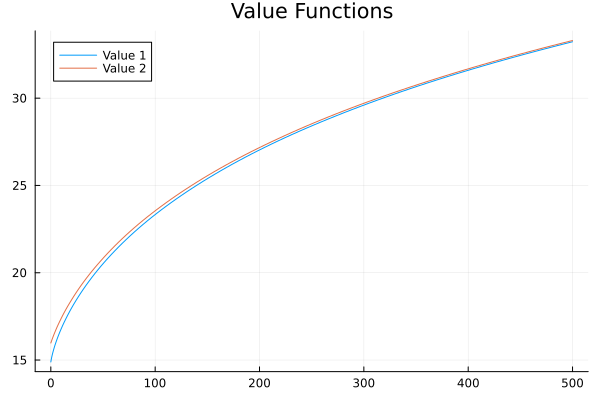

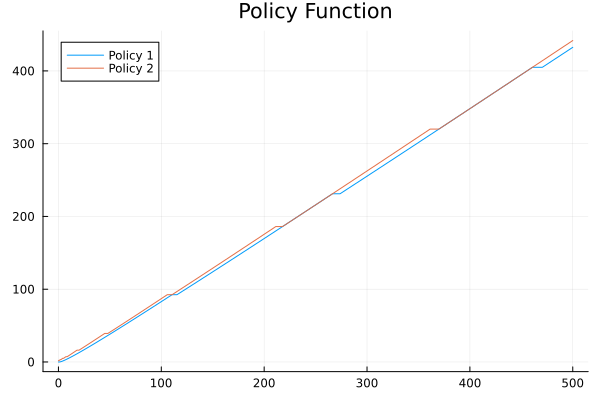

([14.888695554778703 15.975072325078033; 14.906922403990993 15.983978600616739; … ; 33.08088849521194 33.153697354183265; 33.23179898008026 33.30279581697553], [0.0 1.8; 0.0 1.8; … ; 423.20000000000005 432.45000000000005; 432.45000000000005 441.79999999999995])

In [127]:
@time begin
Value, Policy = Bellman_grid_search(Sizes, Params, 1e-8, 10000, 1)
end

In [145]:
function clear_markets(S, P)

    index = zeros(S[3], S[2])

    state, transition = states(S)

    bond_grid = expanding_grid(S)

    q_low = P[1]

    q_high = 1.3*P[1]

    q_update = (q_low + q_high) / 2

    Value, Policy = Bellman_grid_search(Sizes, Params, 1e-8, 10000, q_update)

    M = zeros(S[3], S[2], S[3], S[2])

    for i in 1:S[3]

        for j in 1:S[2]

        index[i,j] = findfirst(isequal(Policy[i,j]), bond_grid)[1]

        end

    end

    for i in 1:S[3]

        for j in 1:S[2]

            for k in 1:S[3]

                for l in 1:S[2]

                    if index[i,j] == bond_grid[k]

                        M[i,j,k,l] = 1/S[2]

                    else 

                        M[i,j,k,l] = 0

                    end

                end

            end

        end

    end

    O = reshape(M, (S[3]*S[2], S[3]*S[2]))
    
    return O
    
end
    

clear_markets (generic function with 1 method)

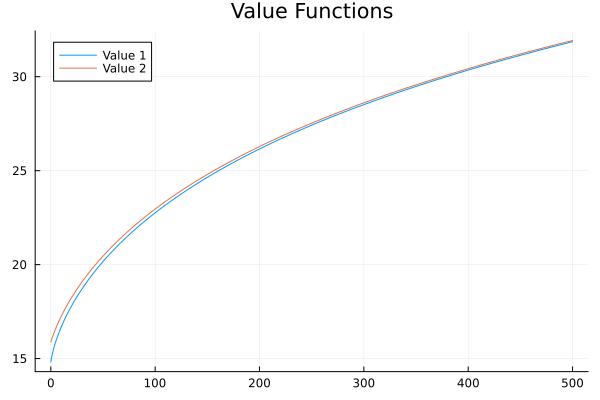

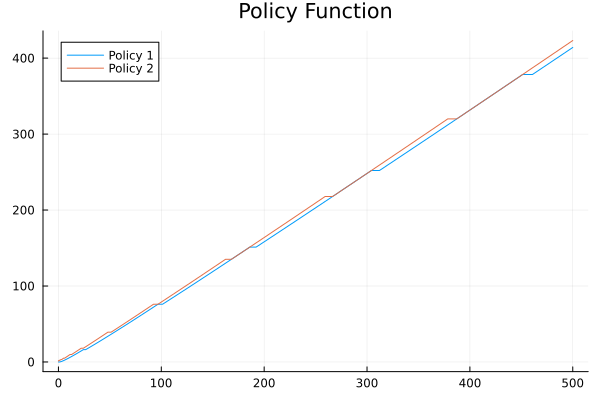

Iterating...
iteration 0 completed with error 0.535574102247999
iteration 25 completed with error 2.926579156792286e-8
converged in 37 iterations


202×202 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [146]:
ind = clear_markets(Sizes, Params)